# Introduction: Home Credit Default Risk Competition
This notebook is intended for those who are new to machine learning competitions or want a gentle introduction to the problem. I purposely avoid jumping into complicated models or joining tohether lots of data in order to show the basics of how to get started in machine learning! Any comments of suggestions are much appreciated.

In this notebook, we will take an initital look at the home Credit default risk  machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classificaiton task:

* **Supervised** : The labels are included in the traning data and the goal is to train a model to learn to predict the lables from the featrues
* **Classification** : The labels is a binary variable, 0 (will repay loan on time), 1(will have difficulty repaying loan)

## Data
The data is povided by Home Credit, a service dedicated to privided lines of credit(loans) to the unbacked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this compeititon on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

* application_train/application_test : the main training and testing data with information about each loan application at home Credit. Every loan has its own row and is identified by the featrue `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0:the loan was repaid or 1:the loan was not repaid.
* bureau : data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance : monthly data about the previous credits in bureau. Each row in one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* previous_application : previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loan. Each previous application has one row ans is identified by the feature `SK_ID_PREV`.
* POS_CASH_BALANCE : monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance : monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment : payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

This diagram shows how all of the data is related:
<img src='img/A Gentle Introduction diagram.png'>

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) ans an example of the expected submission file.

In this notebook, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. With these projects, it's best to build up an understanding of the problem a little at a time rather than diving all the way in and getting completely lost!

## Metric: ROC AUC
Once we have a grasp of the data (reading through the column descriptions helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)

The ROC AUC may sound intimidating, but it is relatively straighforward once you can get your head around the two individual concepts. The Reciever Operating Characteristic (ROC) Curve graphs the true positive rate vuersus the false positive rate :

<img src='img/ROC-curve.png'>

A single line on the graph indicates the curve for a single mdoel, ans movement along a line indiciated changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to ans goes to 1 in the lower left. A curve that is to the left ans above another curve indicates a better model. For example, the blue model is better tthan the red model, whch is better than the black diagonal line which indicates a naive random guessing model.

The Area Under the Curve (AUC) explains itself by its name! It is simply the area under the ROC curve. (This is the intergral of the curve.) This metric is between 0 ans 1 with a better model scoring higher. A model that simply guesses at random will have an ROC ?AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 ans 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalnced classes(we will see this is the case), accuracy is not the best metric. For example, if I wanted to build a model that could detect terrorists with 99.9999% accuracy, I would simply mask a model that predicted every single person was not a terrorist/. Clearly, this would not be effective (the recall would be zero) and we use more advanced metrics such as ROC AUC or the F1 score to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the ROC AUC is a better representation of model performance.

Not that we know the background of the data we are using and the metric to maximize, let's get into exploring the data. In this notebook, as mentioned previously, we will stick to the main data wources and simple models which we can build upon in future work.

## Imports
We are using a typical data science stack : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [1]:
# numpy and pandas for data manipulation
# 나는 넘파이 대신 scipy로 연습.
import scipy
import pandas as pd

# sklearn preprocessing for dealing with categorical variable
from sklearn.preprocessing import LabelEncoder

# File system management
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matpliotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data
First, we can list all the avaliable data files. There are a total of 9 files : 1 main file for training (with target) 1 main file for testing (without target). 1 example submission file, and 6 other files contatining additional information about each loan.

In [2]:
# List files available
print(os.listdir('input'))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


In [3]:
# Training data
app_train = pd.read_csv('input/application_train.csv')
print('Training data shape : ', app_train.shape)
app_train.head()

Training data shape :  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and  122 features (variables) including the `TARGET` (the label we want to predict).

In [4]:
# Testing data features
app_test = pd.read_csv('input/application_test.csv')
print('Testing data shape : ', app_test.shape)
app_test.head()

Testing data shape :  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The test set is considerably smaller ans lack a `TARGET` column.

## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us.  It generally starts out with a hight level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be intersting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

## Examine the Distribution of the Target Column
The target is what we are asked to predict: either a 0 for the loan was repaid on ttime, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

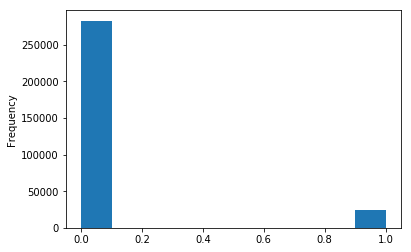

In [6]:
app_train['TARGET'].astype(int).plot.hist()

From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

## Examine Missing Values
Next we can look at the number ans percentage of missing values in each columns.

In [7]:
#Function to calculate missing values by column 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100*df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0:'Missing Values', 1:'% of Total Values'})
    
    #Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values(
        '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'
         'There are ' + str(mis_val_table_ren_columns.shape[0]) + ' columns that have missing values.')
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 122 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4


When it comes time to build our machine learning models, we will have fill in these missing values (known as imutation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputatiton. Another option would be to drop columns with a hight ppercentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns fo now.

## Column Types
Let's look at the number of columns of each data type. `int64` ans `float64` are numeric variables (which can be either discrete or continuous). `object` columns contain strings ans are categorical features.

In [9]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Let's now look at the number of unique entries in each of the `object` (categorical) columns.

In [10]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal witth these categorical variables!

## Encoding Categorical Variables
Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables(except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing tthem off th the model. There are two main ways to carry out this process:

* Label encoding : assign each unique category in a categorical variable with an integer. No new columns are created. 
* One-hot encoding : create a new column for each uique category in a categorical variable. Each obsevation recieves a 1 in the column for its corresponing category ans a 0 in all other new columns.

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1 ) to assign weights which is not what we want. I?f we only have two unique values for a catogorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

### Label Encoding and One-Hot Encoding
Let's implement the policy described above: for any categorical variable(`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [11]:
le = LabelEncoder()
le_count = 0

# iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

3 columns were label encoded.


In [12]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training features shape : ', app_train.shape)
print('Testing features shape : ', app_test.shape)

Training features shape :  (307511, 243)
Testing features shape :  (48744, 239)


In [13]:
train_labels = app_train['TARGET']

# 컬럼 정렬하는 함수, inner join으로 양쪽에 한쪽이라도 없는 컬럼은 제거
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

app_train['TARGET'] = train_labels

print('Training features shape : ', app_train.shape)
print('Testing features shape : ', app_test.shape)

Training features shape :  (307511, 240)
Testing features shape :  (48744, 239)


### Anomalies

In [14]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

문제 없어보임.

In [15]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

최대 값이 1000년이 넘는 시간으로 되어 있으니 문제가 있음. 그리고 음수로 나타내어지는데 이거는 양수임.

Text(0.5, 0, 'Days Employment')

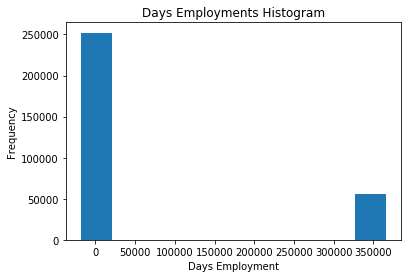

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employments Histogram')
plt.xlabel('Days Employment')

In [17]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on {:.2f}% of loans'.format(100*non_anom['TARGET'].mean()))
print('The anomalies default on {:.2f}% of loans'.format(100*anom['TARGET'].mean()))
print('There are {} anomalus day of employment'.format(len(anom)))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalus day of employment


이상치를 가지고 있는 데이터 샘플이 더 적은 연체율을 보였다. 이상치 데이터의 값들을 nan으로 변경하자.

Text(0.5, 0, 'Days Employment')

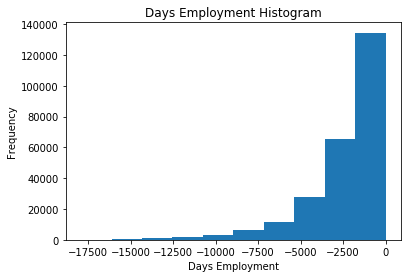

In [18]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

app_train['DAYS_EMPLOYED'].replace({365243: scipy.nan}, inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [19]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243 : scipy.nan}, inplace=True)

print('There are {} anomalies in the test data out of {} entries'.format(
app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations
* .00~.19 'Very weak'
* .20~.39 'Weak'
* .40~.59 'Moderate'
* .60~.79 'Strong'
* .80~1.0 'Very strong'

In [20]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### Effect of Age on Repayment

In [21]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Text(0, 0.5, 'Count')

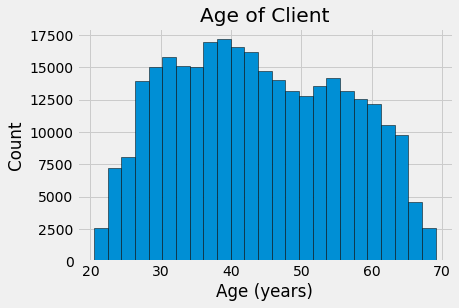

In [22]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH']/365, edgecolor = 'k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution of Ages')

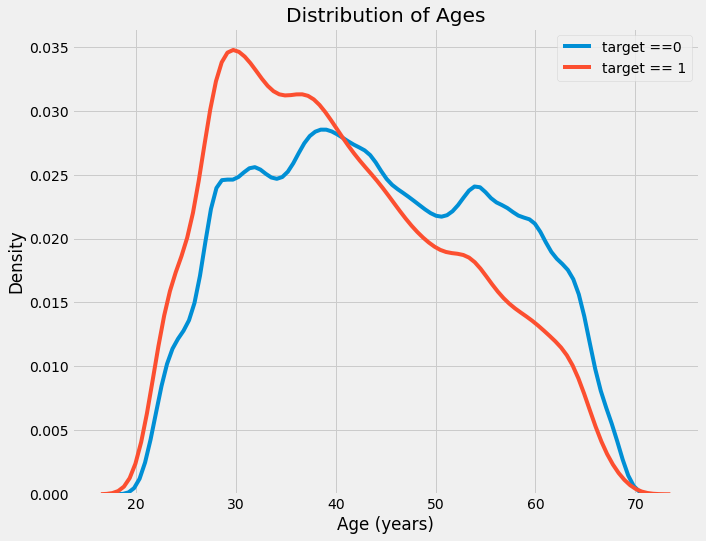

In [23]:
plt.figure(figsize=(10,8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target ==0')

sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH'] / 365, label='target == 1')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

target == 1이 나이가 어린쪽에 치우친 것으로 보아, 상관 관계에서는 유용하지 않은 정보만을 얻은 반면에 kdeplot을 통해 좋은 정보를 얻을 수 있음.

In [24]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=scipy.linspace(20, 70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [25]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

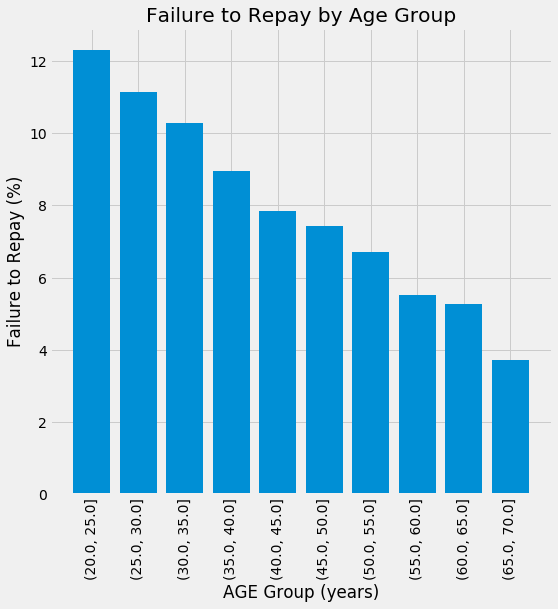

In [26]:
plt.figure(figsize=(8,8))

plt.bar(age_groups.index.astype(str), 100* age_groups['TARGET'])
plt.xticks(rotation=90)
plt.xlabel('AGE Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

어릴수록 연체율이 높다.

### Exterior Sources 
EXT_SOURCE들도 살펴보자.

In [27]:
#Extract The EXT_SOURCE variables ans show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                     'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correation Heatmap')

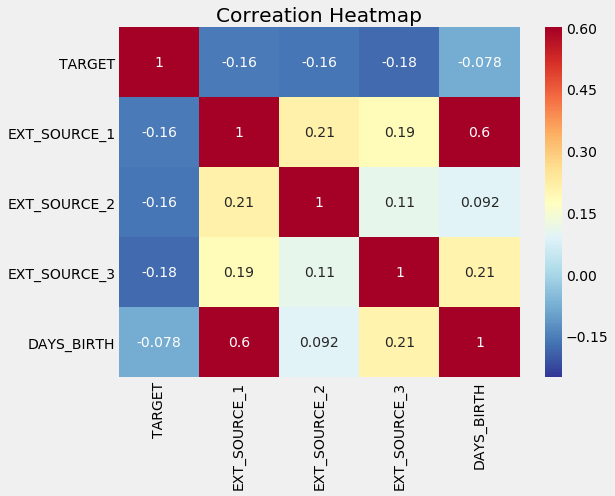

In [28]:
plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25,
           annot = True, vmax = 0.6)
plt.title('Correation Heatmap')

3종류의 EXT_SOURCE 모두 TARGET 변수와 음의 상관 관계를 가지고 있었다. 그리고 EXT_SOURCE_1의 경우에는 DAYS_BIRTH와 높은 양의 상관 관계를 보이므로, 나이와 관련있을 것으로 예상된다.

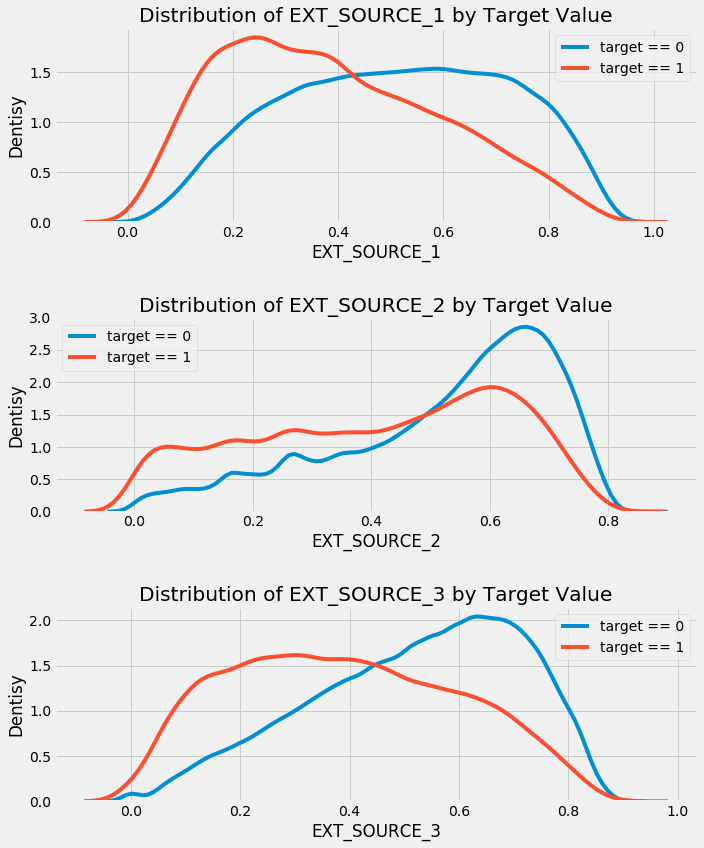

In [29]:
plt.figure(figsize=(10, 12))


# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    isnotnan = ~pd.isna(app_train[source])
    target0 = app_train['TARGET'] == 0
    target1 = app_train['TARGET'] == 1
    sns.kdeplot(app_train.loc[isnotnan & target0, source], label = 'target == 0')
    sns.kdeplot(app_train.loc[isnotnan & target1, source], label = 'target == 1')
    
    plt.title('Distribution of {} by Target Value'.format(source))
    plt.xlabel('{}'.format(source))
    plt.ylabel('Dentisy')
    
plt.tight_layout(h_pad = 2.5)

### Pairs Plot
Pair plot는 각 변수들의 분포와 관계를 한눈에 확인할 수 있어 좋다.

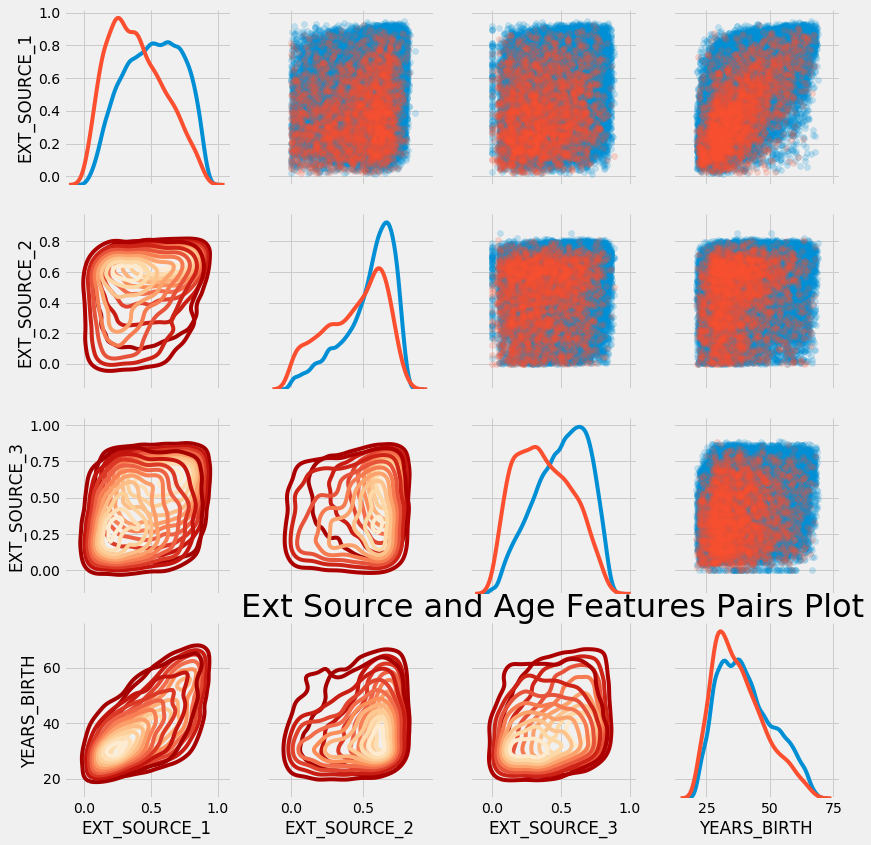

In [30]:
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

plot_data = plot_data.dropna().loc[:100000,:]

def corr_func(x, y, **kwargs):
    r = scipy.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate('r = {:.2f}'.format(r),
               xy=(.2, .8), xycoords=ax.transAxes,
               size=20)
    
grid = sns.PairGrid(data = plot_data, size=3, diag_sharey=False,
                   hue = 'TARGET',
                   vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

grid.map_upper(plt.scatter, alpha = 0.2)

grid.map_diag(sns.kdeplot)

grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.title('Ext Source and Age Features Pairs Plot', size = 32)

plt.show()

## Polynomial Features
다항 변수 만들기. 그냥 제곱하거나 서로 곱하면 됨.
는 일단 패스

In [31]:
poly_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                           'DAYS_BIRTH', 'TARGET']

In [32]:
from sklearn.model_selection import StratifiedKFold

In [33]:
fold = StratifiedKFold(5, shuffle=True)

In [41]:
train_columns = [c for c in app_train if c not in ['SK_ID_CURR', 'TARGET']]

In [42]:
from sklearn.preprocessing import Imputer

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
pred = scipy.zeros((len(app_test), 1))
oof_fold = scipy.zeros((len(app_train), 1))

In [46]:
from sklearn.metrics import roc_auc_score

In [55]:
testid = app_test['SK_ID_CURR']

In [57]:
imputer = Imputer(strategy='median')
app_test = imputer.fit_transform(app_test[train_columns])

In [58]:
for n, (train_idx, valid_idx) in enumerate(fold.split(app_train, app_train['TARGET'].values)):
    print('fold : {}'.format(n+1))
    fold_train = app_train.iloc[train_idx, :][train_columns]
    fold_valid = app_train.iloc[valid_idx, :][train_columns]
    
    imputer = Imputer(strategy='median')
    fold_train = imputer.fit_transform(fold_train)
    imputer = Imputer(strategy='median')
    fold_valid = imputer.fit_transform(fold_valid)
    
    clf = RandomForestClassifier()
    
    clf.fit(fold_train, app_train.iloc[train_idx, :]['TARGET'])
    oof_fold[valid_idx] += clf.predict_proba(fold_valid)[:, 1].reshape((-1, 1))
    
    pred += clf.predict_proba(app_test)[:, 1].reshape((-1, 1))/ fold.n_splits
    
    print('Train score : {} \t Valid score : {}'.format(
        roc_auc_score(app_train.iloc[train_idx,:]['TARGET'], clf.predict_proba(fold_train)[:, 1]),
        roc_auc_score(app_train.iloc[valid_idx, :]['TARGET'], clf.predict_proba(fold_valid)[:, 1])))
    
print('CV score : {}'.format(
    roc_auc_score(app_train['TARGET'], oof_fold)))

fold : 1
Train score : 0.999842477653816 	 Valid score : 0.6201830693092831
fold : 2
Train score : 0.9998255348872849 	 Valid score : 0.6237993100295022
fold : 3
Train score : 0.9997966107569902 	 Valid score : 0.6335809178140541
fold : 4
Train score : 0.9997803522819801 	 Valid score : 0.6200499344145242
fold : 5
Train score : 0.999782532042468 	 Valid score : 0.6282350153250086
CV score : 0.6250932443848484


In [62]:
sub = pd.read_csv('./input/sample_submission.csv')
sub['TARGET'] = pred
sub.to_csv('./input/sub_feature_order_unique.csv', index=False)